In [2]:
from sqlalchemy import create_engine, func
from sqlalchemy.orm import sessionmaker
import sys
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
from DB.models import init_db, Circuit, Season, RacingWeekend, Driver, Session, SessionResult, Lap, Team, DriverTeamSession, TeamCircuitStats, PitStop
from utils import correct_fuel_effect, extract_driver_strategies, calculate_base_sector_times, get_tyre_deg_per_driver

import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from itertools import product

# Initialize database connection
global db_session
engine, db_session = init_db()

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None) 


## 1) Query race into df and pre process

In [3]:
def get_race_session(year, circuit):
	race_session = (db_session.query(Session)
				.join(RacingWeekend, Session.weekend_id == RacingWeekend.racing_weekend_id)
				.join(Circuit, RacingWeekend.circuit_id == Circuit.circuit_id)
				.filter(
					RacingWeekend.year == year,
					Circuit.circuit_name == circuit,
					Session.session_type == "Race"
				)
				.first())
	
	return race_session

def get_race_df(race_session_db):

	laps = race_session_db.laps

	# Convert to DataFrame
	laps_data = []
	for lap in laps:
		# Add a row for Sector 1
		laps_data.append({
			"lap_num": lap.lap_num,
			"sector": 1,
			"stint_num": lap.stint_num,
			"stint_lap": lap.stint_lap,
			"position": lap.position,
			"driver_name": lap.driver.driver_name,
			"driver_number": lap.driver.driver_num,
			"sector_time": lap.s1_time,
			"tyre_type": lap.tyre_type,
			"tyre_laps": lap.tyre_laps,
			"pit": lap.pit,
			"track_status": lap.track_status
		})

		# Add a row for Sector 2
		laps_data.append({
			"lap_num": lap.lap_num,
			"sector": 2,
			"stint_num": lap.stint_num,
			"stint_lap": lap.stint_lap,
			"position": lap.position,
			"driver_name": lap.driver.driver_name,
			"driver_number": lap.driver.driver_num,
			"sector_time": lap.s2_time,
			"tyre_type": lap.tyre_type,
			"tyre_laps": lap.tyre_laps,
			"pit": lap.pit,
			"track_status": lap.track_status
		})

		# Add a row for Sector 3
		laps_data.append({
			"lap_num": lap.lap_num,
			"sector": 3,
			"stint_num": lap.stint_num,
			"stint_lap": lap.stint_lap,
			"position": lap.position,
			"driver_name": lap.driver.driver_name,
			"driver_number": lap.driver.driver_num,
			"sector_time": lap.s3_time,
			"tyre_type": lap.tyre_type,
			"tyre_laps": lap.tyre_laps,
			"pit": lap.pit,
			"track_status": lap.track_status
		})

	# Create a DataFrame from the list of dictionaries
	df = pd.DataFrame(laps_data)
	

	df = df.sort_values(["lap_num", "sector", "position"]).reset_index(drop=True)

	return df


def add_race_data(df):
	# Calculate cumulative race time for each driver
	df["cumulative_time"] = df.groupby("driver_name")["sector_time"].cumsum()
 
	# Calculate rolling pace (average lap time over the last 5 laps)
	df["pace"] = (
		df.groupby(["driver_name", "sector"])["sector_time"]
		.rolling(window=5, min_periods=1)
		.mean()
		.reset_index(level=[0, 1], drop=True)
	)

	# Get car ahead"s cumulative time (car immediately ahead in position for each lap)
	df["front_cumulative_time"] = df.groupby(["lap_num", "sector"])["cumulative_time"].shift(1)
	# This gap is calculated only for drivers who are not in the lead position (position > 1)
	df["gap"] = df["cumulative_time"] - df["front_cumulative_time"]
	df["gap"] = df["gap"].fillna(0)  # Leader has no car ahead, so gap is 0

	# Calculate tyre difference (compared to car immediately ahead in THIS Sector)
	df["front_tyre"] = df.groupby(["lap_num", "sector"])["tyre_type"].shift(1)
	df["tyre_diff"] = df["front_tyre"] - df["tyre_type"]
	df["tyre_diff"] = df["tyre_diff"].fillna(0)  # Leader has no car ahead

	# Calculate tyre age difference (compared to car immediately ahead in THIS Sector)
	df["front_laps"] = df.groupby(["lap_num", "sector"])["stint_lap"].shift(1)
	df["stint_laps_diff"] = df["front_laps"] - df["stint_lap"]
	df["stint_laps_diff"] = df["stint_laps_diff"].fillna(0)  # Leader has no car ahead

	# Calculate DRS availability (within 1s of car ahead IN THIS Sector)
	df["drs_available"] = (
		(df["gap"] <= 1) &
		(df["position"] > 1) &
		(df["lap_num"] > 1)
	)

	# Create target variable for overtaking model (done where its 1 if the driver got overtaken (improved accuracy))
	df["next_position"] = df.groupby("driver_name")["position"].shift(1) 
	df["overtaken"] = ((df["next_position"] < df["position"]) | 
					  (df["next_position"].isna()))
	

	# Cleanup and final sorting
	df = df.drop(columns=["front_cumulative_time", "front_tyre", "next_position"])
	# df = df.sort_values(["lap_num", "sector", "position"]).reset_index(drop=True)

	try:
		new_order = [
			"lap_num", "sector", "stint_num", "stint_lap", "position", "driver_name",
			"driver_number", "sector_time", "gap", "cumulative_time", "tyre_type", "tyre_laps", 
			"pit", "drs_available", "overtaken", "tyre_diff", "front_laps", "stint_laps_diff", "track_status", "pace"
		]

		df = df[new_order]
	except:
		print("dont care")
	return df

race_session_db = get_race_session(2022, "Sakhir")

df = get_race_df(race_session_db)
df = add_race_data(df)


# df

In [4]:
def setup_race_data(race_df, race_session_db):
	driver_strategies = extract_driver_strategies(race_df)
	
	# Extract tyre degradation curves
	driver_tyre_coefficients = get_tyre_deg_per_driver(race_df)
	
	# Precompute driver strategies

	# Correct fuel effects in the race data
	max_laps = race_df["lap_num"].max()
	race_df = correct_fuel_effect(race_df)

	drivers = race_df["driver_number"].unique()

	base_sector_times = calculate_base_sector_times(race_df)

	driver_names = {
		driver: race_df[race_df["driver_number"] == driver]["driver_name"].iloc[0]
		for driver in drivers
	}

	# Precompute fuel corrections
	max_fuel_kg = 110
	fuel_effect_per_kg = 0.03
	fuel_corrections = {
		lap: (max_fuel_kg - (lap - 1) * (max_fuel_kg / max_laps)) * fuel_effect_per_kg
		for lap in range(1, max_laps + 1)
	}


	# 
	session_results = (
		db_session.query(SessionResult.grid_pos, Driver.driver_num, SessionResult.end_status)
		.join(Session, Session.session_id == SessionResult.session_id)
		.join(Driver, Driver.driver_id == SessionResult.driver_id)
		.filter(SessionResult.session_id == race_session_db.session_id)
		.all()
	)
	# Convert session results to a dictionary
	starting_positions = {driver_num: grid_pos for grid_pos, driver_num, _ in session_results}

	# Initialize an empty dictionary to store retirements by lap
	retirements_by_lap = {}

	# Iterate through session results to determine retirements
	for driver_id, driver_num, end_status in session_results:
		# Check if the driver retired (end_status is not "Finished" or "+1 Lap")
		if end_status and not (end_status.startswith("Finished") or end_status.startswith("+")):
			# Find the maximum lap number for the driver (last recorded lap)
			lap_retired = df[df["driver_number"] == driver_num]["lap_num"].max()
			
			# Add the driver to the list of retirees for the corresponding lap
			if lap_retired not in retirements_by_lap:
				retirements_by_lap[lap_retired] = []
			retirements_by_lap[lap_retired].append(driver_num)

	# Output the retirements dictionary
	print(retirements_by_lap)

	# Get initial positions (starting grid positions) for each driver

	df["starting_position"] = None  # Initialize column with None
	for driver_num, grid_pos in starting_positions.items():
		# Find the first occurrence of the driver
		first_row_index = df[df["driver_number"] == driver_num].index[0]
		df.at[first_row_index, "starting_position"] = grid_pos

		
	
	# Get safety car laps
	filtered_df = race_df[race_df["track_status"] != 1]
	
	# Group by lap_num and convert each group to a list of dictionaries
	slow_laps = {}
	for lap_num, group in filtered_df.groupby("lap_num"):
		slow_laps[lap_num] = group.to_dict(orient="records")
	

	return {
		"driver_tyre_coefficients": driver_tyre_coefficients,
		"driver_strategies": driver_strategies,
		"race_df": race_df,
		"max_laps": max_laps,
		"drivers": drivers,
		"driver_names": driver_names,
		"initial_positions": starting_positions,
		"base_sector_times": base_sector_times,
		"fuel_corrections": fuel_corrections,
		"slow_laps": slow_laps,
		"retirement_laps": retirements_by_lap
	}

In [11]:
df = df.dropna(subset=['sector_time']).reset_index(drop=True)
df = df.sort_values(["lap_num", "sector", "position"]).reset_index(drop=True)
race_data = setup_race_data(df, race_session_db)



{np.int64(56): [11], np.int64(54): [1], np.int64(44): [10]}


In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tyre_degradation(driver_number, driver_tyre_coefficients, max_laps=40):
    """
    Plot tyre degradation for each sector separately given a driver number.
    
    Parameters:
        driver_number (int): The driver number to plot.
        driver_tyre_coefficients (dict): The dictionary of tyre coefficients returned by get_tyre_deg_per_driver.
        max_laps (int): The maximum number of laps to plot for tyre degradation.
    """
    # Check if the driver exists in the coefficients dictionary
    if driver_number not in driver_tyre_coefficients:
        print(f"No data available for driver {driver_number}.")
        return
    
    # Get the coefficients for the specified driver
    driver_coeffs = driver_tyre_coefficients[driver_number]
    
    # Extract all unique sectors from the coefficients
    sectors = set()
    for tyre_sector_coeffs in driver_coeffs.values():
        sectors.update(tyre_sector_coeffs.keys())
    sectors = sorted(sectors)  # Sort sectors for consistent ordering
    
    # Create a figure with subplots for each sector
    num_sectors = len(sectors)
    fig, axes = plt.subplots(num_sectors, 1, figsize=(12, 6 * num_sectors), sharex=True)
    
    # Ensure axes is iterable even if there's only one sector
    if num_sectors == 1:
        axes = [axes]
    
    # Loop through each sector and plot tyre degradation
    for ax, sector in zip(axes, sectors):
        # Loop through each tyre type
        for tyre, tyre_sector_coeffs in driver_coeffs.items():
            tyre_name = {1: "Soft", 2: "Medium", 3: "Hard"}.get(tyre, f"Tyre {tyre}")
            
            # Check if the current tyre has data for this sector
            if sector in tyre_sector_coeffs:
                a, b, c = tyre_sector_coeffs[sector]  # Extract coefficients
                
                # Generate lap numbers (x-axis)
                laps = np.arange(0, max_laps + 1)
                
                # Calculate normalised sector times using the polynomial model
                sector_times = a * laps**2 + b * laps + c
                
                # Plot the degradation curve for this tyre type and sector
                ax.plot(laps, sector_times, label=f"{tyre_name}")
        
        # Add labels, legend, and title for the current sector
        ax.set_title(f"Sector {sector} - Tyre Degradation for Driver {driver_number}")
        ax.set_ylabel("Normalised Sector Time")
        ax.legend()
        ax.grid(True)
    
    # Add a shared x-axis label
    axes[-1].set_xlabel("Lap Number")
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Example usage:
# Assuming `driver_tyre_coefficients` is the output of `get_tyre_deg_per_driver`
# driver_number = 1  # Replace with the desired driver number
# plot_tyre_degradation_separate_sectors(driver_number, driver_tyre_coefficients)

# Example usage:
# Assuming `driver_tyre_coefficients` is the output of `get_tyre_deg_per_driver`
print(race_data["driver_tyre_coefficients"][6])
# plot_tyre_degradation(6, race_data["driver_tyre_coefficients"])

{np.int64(1): {np.int64(1): [0.010266500218433686, -0.1461933996634331, 1.125122322408248], np.int64(2): [0.00539685299820531, -0.059803543181987336, 1.848182567198233], np.int64(3): [0.0029181862804478474, 0.002016067481319536, 0.5149041314619819]}, np.int64(2): {np.int64(1): [0.0030262462316062787, 0.025521508545123577, 0.3843854209512424], np.int64(2): [3.898978701406083e-15, 0.06683269404155777, 1.3618634773041431], np.int64(3): [0.0035337900731656083, -0.03167650527474976, 0.7968803800332871]}, 3: {np.int64(1): [0.0049934247395284235, -0.034857470768172104, 0.5193175540493716], np.int64(2): [0.004619753459948942, -0.010512332371013886, 0.576779688931991], np.int64(3): [0.0005597875815398703, 0.02602432910097873, 0.21227823600248444]}}


{np.int64(1): {np.int64(1): [0.010266500218433686, -0.1461933996634331, 1.125122322408248], np.int64(2): [0.00539685299820531, -0.059803543181987336, 1.848182567198233], np.int64(3): [0.0029181862804478474, 0.002016067481319536, 0.5149041314619819]}, np.int64(2): {np.int64(1): [0.0030262462316062787, 0.025521508545123577, 0.3843854209512424], np.int64(2): [3.898978701406083e-15, 0.06683269404155777, 1.3618634773041431], np.int64(3): [0.0035337900731656083, -0.03167650527474976, 0.7968803800332871]}, 3: {np.int64(1): [0.0049934247395284235, -0.034857470768172104, 0.5193175540493716], np.int64(2): [0.004619753459948942, -0.010512332371013886, 0.576779688931991], np.int64(3): [0.0005597875815398703, 0.02602432910097873, 0.21227823600248444]}}

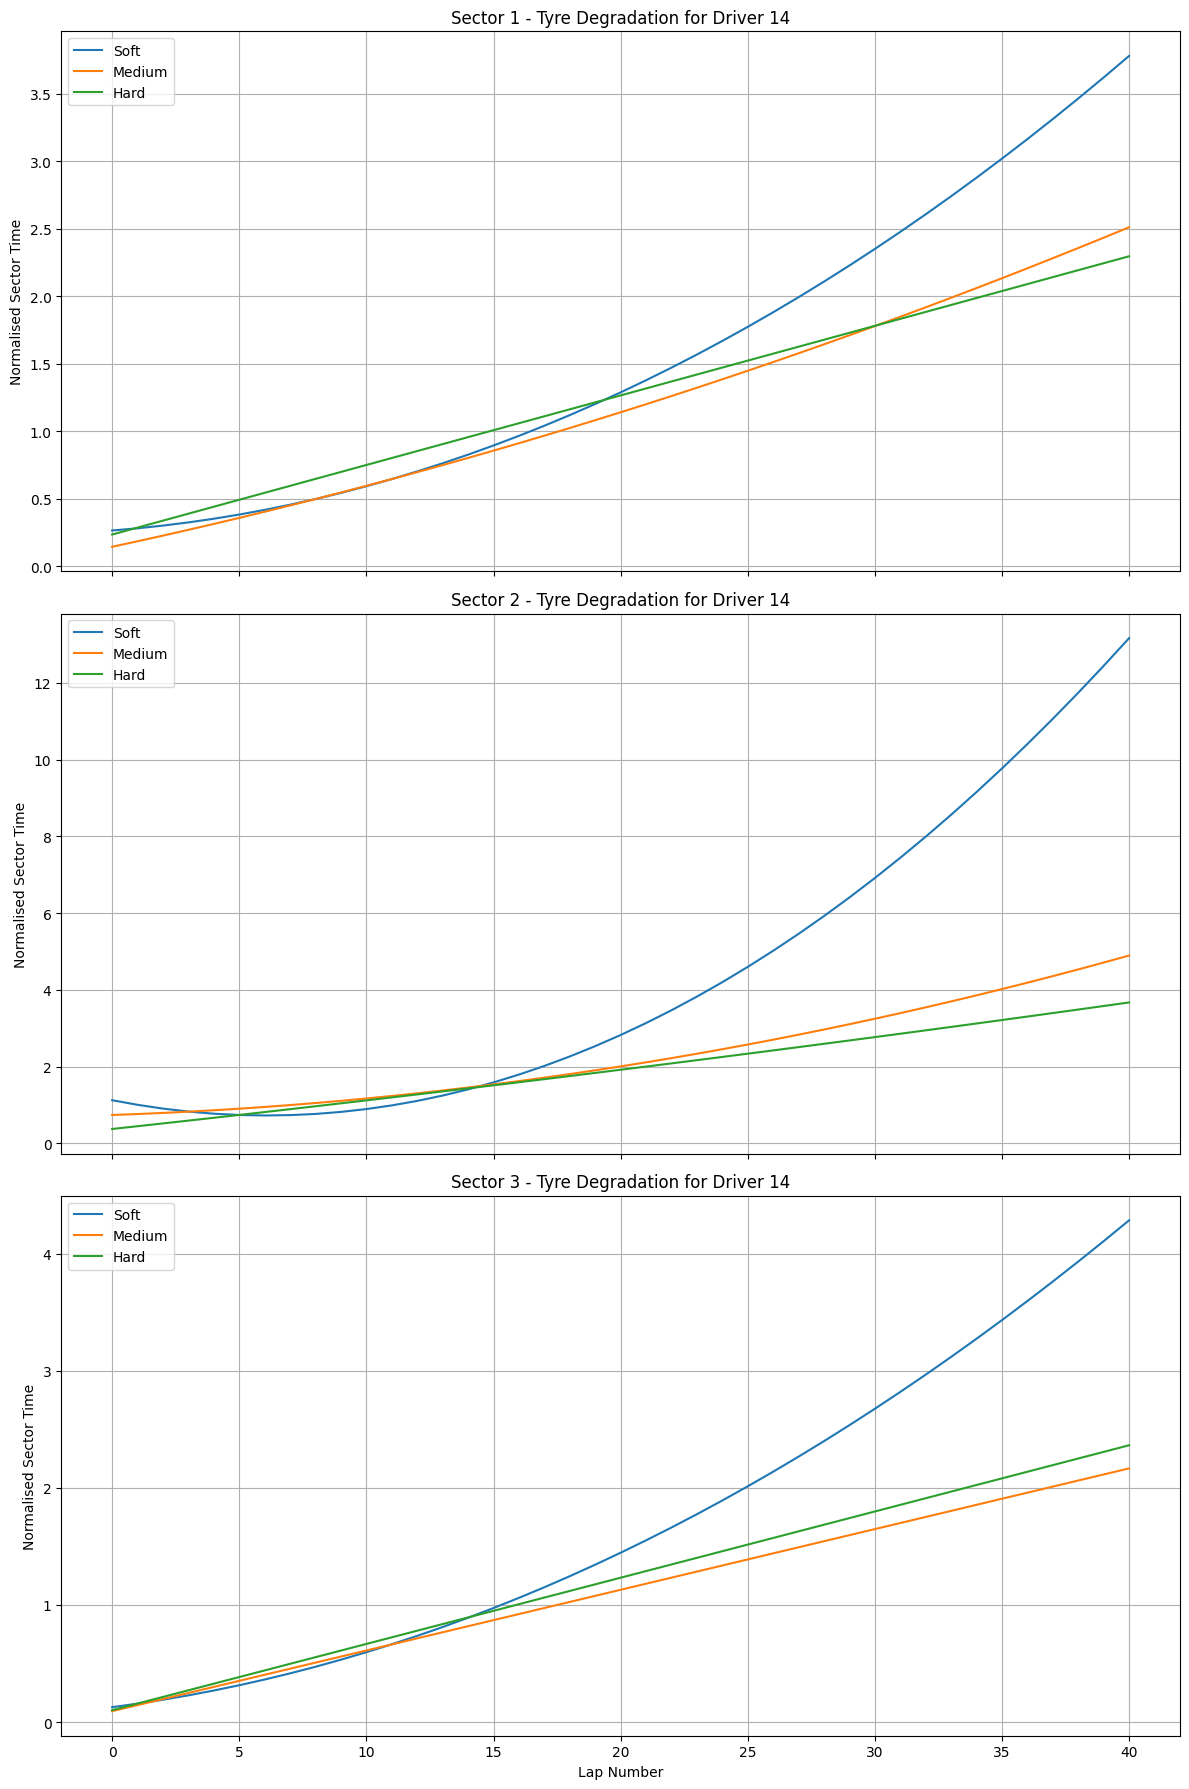

In [13]:
plot_tyre_degradation(14, race_data["driver_tyre_coefficients"])

In [14]:
race_data["base_sector_times"][6]

{np.int64(2): np.float64(41.62517543859649),
 np.int64(3): np.float64(23.238175438596492),
 np.int64(1): np.float64(30.612473684210524)}

In [15]:
race_data["base_sector_times"][14]

{np.int64(2): np.float64(41.58482456140351),
 np.int64(3): np.float64(23.339280701754387),
 np.int64(1): np.float64(30.621473684210525)}